In [1]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

import pandas as pd

# Load the dataset
df = pd.read_csv('Phishing Websites Engineered.csv')

# Features and target
X = df.drop(columns='target')
y = df['target']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [2]:
dtc_model = DecisionTreeClassifier(criterion='entropy', random_state=42)
dtc_model.fit(X_train, y_train)

DecisionTreeClassifier(criterion='entropy', random_state=42)

In [3]:
y_pred2 = dtc_model.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred2))
print(classification_report(y_test, y_pred2))


Accuracy: 0.923931623931624
              precision    recall  f1-score   support

          -1       0.93      0.93      0.93       620
           1       0.92      0.92      0.92       550

    accuracy                           0.92      1170
   macro avg       0.92      0.92      0.92      1170
weighted avg       0.92      0.92      0.92      1170



🔍 SHAP Summary Plot - Decision Tree


<ipython-input-12-6c0ef6df710c>:21: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(dtc_shap_values, sample, show=False)  # show=False to control display


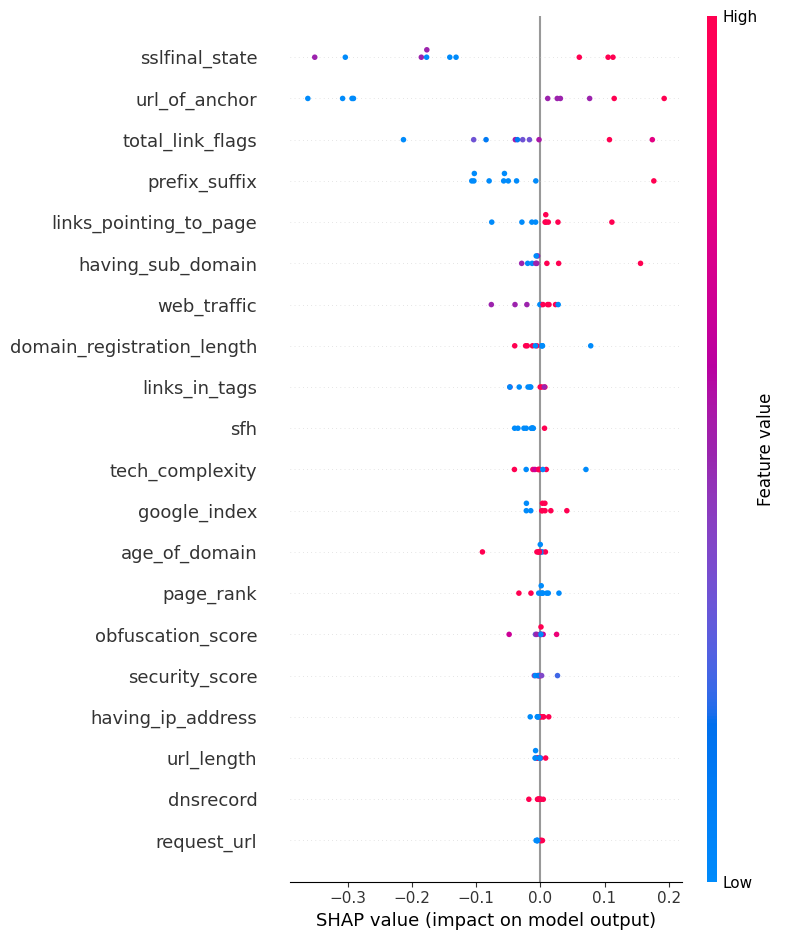

In [12]:
background = shap.sample(X_train, 100, random_state=42)

# Create SHAP TreeExplainer for Random Forest
dtc_explainer = shap.TreeExplainer(dtc_model, background)

# Pick a few test instances
sample = X_test.sample(10, random_state=42)

# Compute SHAP values
dtc_shap_values = dtc_explainer.shap_values(sample)

# For binary classification, select SHAP values for the positive class (index 1)
# For multiclass, you may need to loop through each class or select one
if len(dtc_shap_values.shape) == 3:
    dtc_shap_values = dtc_shap_values[:, :, 1]
elif isinstance(dtc_shap_values, list):
    dtc_shap_values = dtc_shap_values[1]

# Visualize SHAP summary plot
print("🔍 SHAP Summary Plot - Decision Tree")
shap.summary_plot(dtc_shap_values, sample, show=False)  # show=False to control display
plt.tight_layout()  # Adjust layout to prevent clipping
plt.show()  # Explicitly display the plot

In [5]:
!pip install lime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 7.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=9617a0cd12e09b664fef6a6892539f2271ec5424298877be37646f9b3ad51bfe
  Stored in directory: /root/.cache/pip/wheels/85/fa/a3/9c2d44c9f3cd77cf4e533b58900b2bf4487f2a17e8ec212a3d
Successfully built lime


In [6]:
import lime
import lime.lime_tabular
import numpy as np


In [7]:
lime_explainer = lime.lime_tabular.LimeTabularExplainer(
    training_data=np.array(X_train),
    feature_names=X.columns.tolist(),
    class_names=['Legitimate', 'Phishing'],
    mode='classification'
)

In [8]:
def explain_instance_lime(model, model_name):
    i = np.random.randint(0, X_test.shape[0])
    exp = lime_explainer.explain_instance(
        X_test.iloc[i],
        model.predict_proba,
        num_features=10
    )
    print(f"\n🔍 LIME Explanation for model: {model_name} on instance {i}")
    exp.show_in_notebook(show_table=True)
    return exp

In [9]:
# Explain one instance with each model
explain_instance_lime(dtc_model, "Decision Tree")

/usr/local/lib/python3.11/dist-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/usr/local/lib/python3.11/dist-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/usr/local/lib/python3.11/dist-packages/lime/lime_tabular.py:544: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.


🔍 LIME Explanation for model: Decision Tree on instance 289


# PFI

Top 5 Features by PFI:
              Feature  Importance
13      url_of_anchor    0.145385
7      sslfinal_state    0.112991
5       prefix_suffix    0.028376
15                sfh    0.021197
6   having_sub_domain    0.011453


<Figure size 1000x600 with 0 Axes>

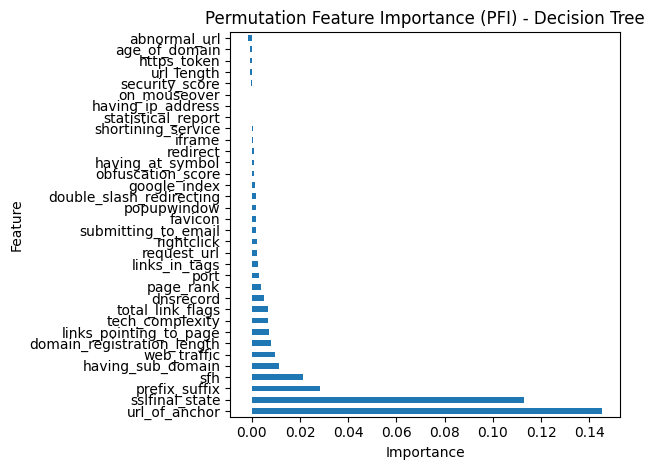

In [10]:
from sklearn.inspection import permutation_importance, PartialDependenceDisplay
import matplotlib.pyplot as plt

pfi_result = permutation_importance(dtc_model, X_test, y_test, n_repeats=10, random_state=42)

pfi_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': pfi_result.importances_mean
}).sort_values(by='Importance', ascending=False)

print("Top 5 Features by PFI:")
print(pfi_df.head())

plt.figure(figsize=(10, 6))
pfi_df.plot(kind='barh', x='Feature', y='Importance', legend=False)
plt.title("Permutation Feature Importance (PFI) - Decision Tree")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

top_features = pfi_df['Feature'].head(2).tolist()


# PDP

Partial Dependence Plots for Top Features: ['url_of_anchor', 'sslfinal_state']


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


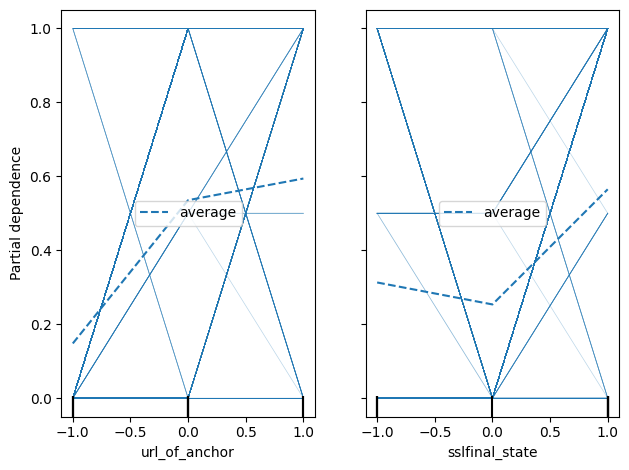

In [11]:
print(f"Partial Dependence Plots for Top Features: {top_features}")
PartialDependenceDisplay.from_estimator(dtc_model, X_test, top_features, kind='both', grid_resolution=20)
plt.tight_layout()
plt.show()